# Training RGCN Recommender on INSPIRED Dataset

This notebook trains the RGCN-based movie recommender on the INSPIRED dataset.

## Environmental Setup

In [1]:
import os
import sys
from pathlib import Path

# Set working directory
os.chdir("..")

# Add project root to Python path
project_root = os.getcwd()
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Check current directory
current_directory = os.getcwd()
print("Project Root:", project_root)
print("Current Working Directory:", current_directory)

Project Root: C:\Users\91953\Documents\GitHub\RAG-Movie-CRS
Current Working Directory: C:\Users\91953\Documents\GitHub\RAG-Movie-CRS


In [2]:
!pip install -r requirements.txt

In [3]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from pathlib import Path
from datetime import datetime
from collections import Counter
import matplotlib.pyplot as plt

# Import RGCN model
from scripts.rgcn_recommender import (
    RGCNRecommender,
    INSPIREDGraphBuilder,
    train_rgcn
)

In [4]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.9.1+cpu
CUDA available: False
CUDA version: None


## DATA PREPARATION FOR TRAINING

### Load Dataset And Create Training Dataset

In [5]:
print("STEP 1: LOADING DATA AND BUILDING GRAPH")

# Initialize graph builder
dataset_dir = "data"
graph_builder = INSPIREDGraphBuilder(dataset_dir=dataset_dir)

# Load movie database
print("\nLoading movie database...")
movie_df = graph_builder.load_movie_database()

# Build graph from dialogs
print("\nBuilding knowledge graph from training dialogs...")
graph_data = graph_builder.build_graph_from_dialogs(
    split="train",
    max_dialogs=None
)


print("GRAPH STATISTICS")
print(f"Total nodes: {graph_data['num_nodes']}")
print(f"Total edges: {graph_data['edge_index'].shape[1]}")
print(f"Number of users: {len(graph_builder.user_to_idx)}")
print(f"Number of movies: {len(graph_builder.movie_to_idx)}")
print(f"Number of relations: {len(graph_builder.relation_types)}")

STEP 1: LOADING DATA AND BUILDING GRAPH

Loading movie database...
Loading 17869 movies into graph...
Added 16764 movie nodes

Building knowledge graph from training dialogs...

Building graph from dialogs...
Using 'movies' and 'text' columns


Processing dialogs: 100%|██████████| 801/801 [00:28<00:00, 28.36it/s]

Processed 801 conversations
Total nodes: 17565
Total users: 801
Total movies: 16764
Edges added: 3064
Matched movies: 3064
Unmatched movies: 1259
Created graph with 17565 nodes and 3064 edges
GRAPH STATISTICS
Total nodes: 17565
Total edges: 3064
Number of users: 801
Number of movies: 16764
Number of relations: 5


In [6]:
# ============================================================
# DIAGNOSTIC: Check Graph Structure
# ============================================================

print("="*60)
print("GRAPH DIAGNOSTIC")
print("="*60)

print(f"\nNodes:")
print(f"  Total users: {len(graph_builder.user_to_idx)}")
print(f"  Total movies: {len(graph_builder.movie_to_idx)}")
print(f"  Total nodes: {graph_data['num_nodes']}")

print(f"\nEdges:")
print(f"  Total edges: {graph_data['edge_index'].shape[1]}")

print(f"\nEdges by relation type:")
for rel_name, rel_id in graph_builder.relation_types.items():
    edges_of_type = (graph_data['edge_type'] == rel_id).sum().item()
    print(f"  {rel_name}: {edges_of_type} edges")

print(f"\nSample user interactions:")
sample_users = list(graph_builder.user_to_idx.values())[:5]
for user_idx in sample_users:
    user_movies = []
    for rel_type, edges in graph_builder.edges.items():
        user_movies.extend([dst for src, dst in edges if src == user_idx])
    
    user_id = graph_builder.idx_to_user.get(user_idx, "Unknown")
    print(f"  User {user_id}: {len(user_movies)} movie interactions")



GRAPH DIAGNOSTIC

Nodes:
  Total users: 801
  Total movies: 16764
  Total nodes: 17565

Edges:
  Total edges: 3064

Edges by relation type:
  USER_LIKES: 1068 edges
  USER_DISLIKES: 42 edges
  USER_MENTIONED: 1954 edges
  MOVIE_GENRE: 0 edges
  MOVIE_SIMILAR: 0 edges

Sample user interactions:
  User 20191126-061250_477_live.pkl: 6 movie interactions
  User 20191126-112230_370_live.pkl: 4 movie interactions
  User 20191126-114841_816_live.pkl: 12 movie interactions
  User 20191126-170006_197_live.pkl: 1 movie interactions
  User 20191126-170349_558_live.pkl: 11 movie interactions


In [7]:
# Check movie name formats
print("Sample dialog movies:")
import pandas as pd
dialog_df = pd.read_csv("data/processed/train.tsv", sep='\t')
sample_dialog_movies = dialog_df['movies'].dropna().head(10).tolist()
for movie in sample_dialog_movies:
    print(f"  '{movie}'")

print("\nSample database movies:")
sample_db_movies = list(graph_builder.movie_to_idx.keys())[:10]
for movie in sample_db_movies:
    print(f"  '{movie}'")

Sample dialog movies:
  'Knives Out (2019)'
  'Joker (2019)'
  'I Am Michael (2015)'
  'Star Wars (1977)'
  'John Wick (2014)'
  'I Am Legend (2007)'
  'Marley (2012)'
  'Knives Out (2019); Given (2017);  Action (1980)'
  'The Avengers (2012)'
  'Terminator (1984)'

Sample database movies:
  'Antlers'
  'Bloodshot'
  'Jungle Cruise'
  'Onward'
  'The Turning'
  'The Gentlemen'
  'The King's Man'
  'The Secret Garden'
  'Like a Boss'
  'Bad Boys for Life'


### Initialize Model

In [8]:
print("STEP 2: INITIALIZING RGCN MODEL")

# Configuration
HIDDEN_DIM = 128
NUM_LAYERS = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_relations = len(graph_builder.relation_types)

model = RGCNRecommender(
    num_nodes=graph_data['num_nodes'],
    num_relations=num_relations,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS
)

model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Architecture:")
print(f"  Total nodes: {graph_data['num_nodes']}")
print(f"  Relations: {num_relations}")
print(f"  Hidden dimension: {HIDDEN_DIM}")
print(f"  Number of layers: {NUM_LAYERS}")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Device: {device}")

STEP 2: INITIALIZING RGCN MODEL

Model Architecture:
  Total nodes: 17565
  Relations: 5
  Hidden dimension: 128
  Number of layers: 2
  Total parameters: 2,478,209
  Trainable parameters: 2,478,209
  Device: cpu


# TRAINING

### Training Loop

In [9]:
print("STEP 3: TRAINING RGCN MODEL")

# Configuration
NUM_EPOCHS = 10 # TODO: change to 50 after debugging 
LEARNING_RATE = 0.0001

# Create checkpoint directory
checkpoint_dir = Path("models/rgcn_checkpoints")
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# Move graph data to device
graph_data['edge_index'] = graph_data['edge_index'].to(device)
graph_data['edge_type'] = graph_data['edge_type'].to(device)

# Train the model
print(f"\nStarting training for {NUM_EPOCHS} epochs...")
print(f"Learning rate: {LEARNING_RATE}")

trained_model, history = train_rgcn(
    model=model,
    graph_data=graph_data,
    graph_builder=graph_builder,
    num_epochs=NUM_EPOCHS,
    lr=LEARNING_RATE
)

print("TRAINING COMPLETE")

STEP 3: TRAINING RGCN MODEL

Starting training for 10 epochs...
Learning rate: 0.0001
TRAINING RGCN MODEL (DEBUG MODE)
Total users: 801
Total movies: 16764
Epoch  1 | Avg: 0.5143 | Min: 0.2627 | Max: 1.8764 | Std: 0.1645 | Batches: 191 | Skipped: 9
Epoch  2 | Avg: 0.3822 | Min: 0.1113 | Max: 4.3148 | Std: 0.4713 | Batches: 184 | Skipped: 16
Epoch  3 | Avg: 0.2678 | Min: 0.0324 | Max: 4.3972 | Std: 0.5173 | Batches: 191 | Skipped: 9
Epoch  4 | Avg: 0.2315 | Min: 0.0224 | Max: 3.2577 | Std: 0.4281 | Batches: 195 | Skipped: 5
Epoch  5 | Avg: 0.1557 | Min: 0.0118 | Max: 1.1300 | Std: 0.1944 | Batches: 189 | Skipped: 11
Epoch  6 | Avg: 0.1645 | Min: 0.0059 | Max: 4.5267 | Std: 0.4473 | Batches: 190 | Skipped: 10
Epoch  7 | Avg: 0.1030 | Min: 0.0032 | Max: 0.6792 | Std: 0.1310 | Batches: 194 | Skipped: 6
Epoch  8 | Avg: 0.1865 | Min: 0.0024 | Max: 6.7427 | Std: 0.5762 | Batches: 191 | Skipped: 9
Epoch  9 | Avg: 0.1437 | Min: 0.0017 | Max: 4.1682 | Std: 0.3712 | Batches: 190 | Skipped: 10
Epo

### Save Final Model

In [10]:
print("STEP 4: SAVING MODEL")

checkpoint_path = checkpoint_dir / "rgcn_model.pt"

torch.save({
    'model_state_dict': trained_model.state_dict(),
    'num_nodes': graph_data['num_nodes'],
    'num_relations': num_relations,
    'hidden_dim': HIDDEN_DIM,
    'num_layers': NUM_LAYERS,
    'movie_to_idx': graph_builder.movie_to_idx,
    'idx_to_movie': graph_builder.idx_to_movie,
    'user_to_idx': graph_builder.user_to_idx,
    'idx_to_user': graph_builder.idx_to_user,
    'relation_types': graph_builder.relation_types,
    'edge_index': graph_data['edge_index'].cpu(),
    'edge_type': graph_data['edge_type'].cpu()
}, checkpoint_path)

print(f"\nModel saved successfully!")
print(f"  Location: {checkpoint_path}")

STEP 4: SAVING MODEL

Model saved successfully!
  Location: models\rgcn_checkpoints\rgcn_model.pt


### VIZ TRAINING HISTORY

In [11]:
print("STEP 5: SAVING TRAINING HISTORY")

import json
from pathlib import Path

# Make sure checkpoint directory exists
checkpoint_dir = Path("models/rgcn_checkpoints")
checkpoint_dir.mkdir(parents=True, exist_ok=True)

# Save history as JSON
history_path = checkpoint_dir / 'training_history.json'
with open(history_path, 'w') as f:
    json.dump(history, f, indent=2)

print(f"Training history saved to: {history_path}")

# Print summary
best_epoch = history['epoch'][np.argmin(history['train_loss'])]
best_loss = min(history['train_loss'])

print(f"\nTraining Summary:")
print(f"  Total Epochs: {NUM_EPOCHS}")
print(f"  Best Epoch: {best_epoch}")
print(f"  Best Loss: {best_loss:.4f}")
print(f"  Final Loss: {history['train_loss'][-1]:.4f}")

STEP 5: SAVING TRAINING HISTORY
Training history saved to: models\rgcn_checkpoints\training_history.json

Training Summary:
  Total Epochs: 10
  Best Epoch: 7
  Best Loss: 0.1030
  Final Loss: 0.1504


## PLOT TRAINING HISTORY

✓ Interactive plot saved to: models\rgcn_checkpoints\training_plot.html
  Open this file in your web browser to view the plot
  (PNG export requires kaleido: pip install kaleido)


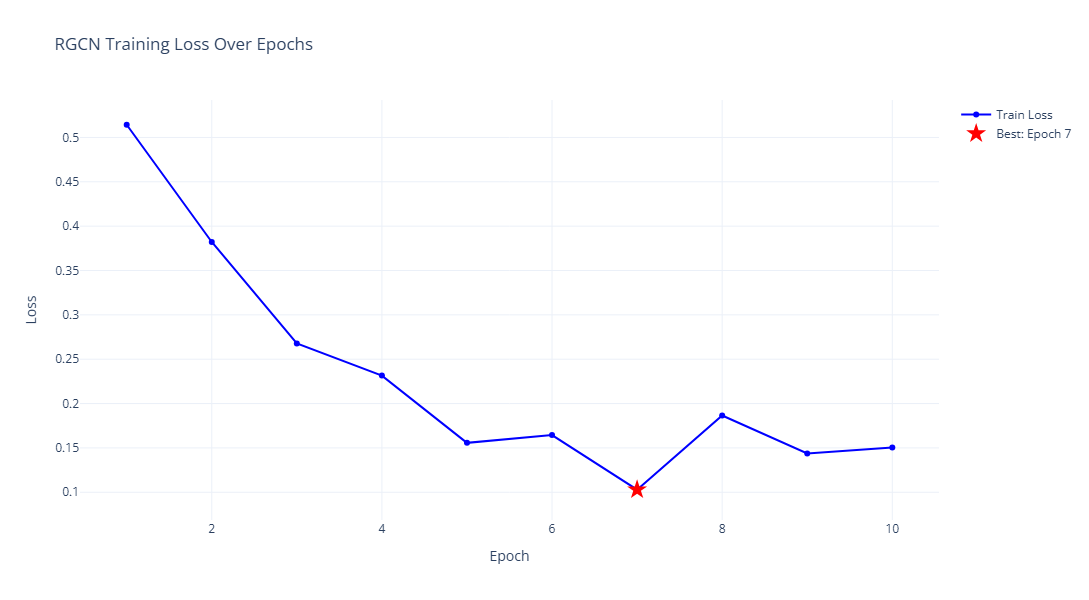


✓ Best epoch: 7 with loss: 0.1030


In [12]:
import json
from pathlib import Path

# Install plotly if needed
try:
    import plotly.graph_objects as go
except ImportError:
    print("Installing plotly...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'plotly'])
    import plotly.graph_objects as go

# Load the saved history
history_path = Path("models/rgcn_checkpoints/training_history.json")

if not history_path.exists():
    print(f"File not found: {history_path}")
else:
    with open(history_path, 'r') as f:
        history = json.load(f)
    
    # Find best epoch
    best_epoch_idx = history['train_loss'].index(min(history['train_loss']))
    best_epoch = history['epoch'][best_epoch_idx]
    best_loss = history['train_loss'][best_epoch_idx]
    
    # Create interactive plot with Plotly
    fig = go.Figure()
    
    # Add training loss line
    fig.add_trace(go.Scatter(
        x=history['epoch'],
        y=history['train_loss'],
        mode='lines+markers',
        name='Train Loss',
        line=dict(color='blue', width=2),
        marker=dict(size=6)
    ))
    
    # Add best epoch marker
    fig.add_trace(go.Scatter(
        x=[best_epoch],
        y=[best_loss],
        mode='markers',
        name=f'Best: Epoch {best_epoch}',
        marker=dict(size=15, color='red', symbol='star')
    ))
    
    # Update layout
    fig.update_layout(
        title='RGCN Training Loss Over Epochs',
        xaxis_title='Epoch',
        yaxis_title='Loss',
        hovermode='x unified',
        template='plotly_white',
        width=1000,
        height=600
    )
    
    # Save as interactive HTML
    html_path = Path("models/rgcn_checkpoints/training_plot.html")
    fig.write_html(str(html_path))
    print(f"✓ Interactive plot saved to: {html_path}")
    print(f"  Open this file in your web browser to view the plot")
    
    # Also save as static image (PNG)
    try:
        png_path = Path("models/rgcn_checkpoints/training_plot.png")
        fig.write_image(str(png_path))
        print(f"✓ Static plot saved to: {png_path}")
    except:
        print("  (PNG export requires kaleido: pip install kaleido)")
    
    # Display in notebook (should be stable)
    fig.show()
    
    print(f"\n✓ Best epoch: {best_epoch} with loss: {best_loss:.4f}")

In [14]:
# ============================================================
# EVALUATION: Standard Metrics (HIT, MRR, NDCG, Recall)
# ============================================================

print("="*60)
print("EVALUATION ON TEST SET")
print("="*60)

# Evaluation metrics class
class RGCNEvaluator:
    """Evaluate RGCN recommender"""
    
    def __init__(self, k_values=[1, 3, 5, 10]):
        self.k_values = k_values
        self.reset()
    
    def reset(self):
        self.metrics = {f'HIT@{k}': [] for k in self.k_values}
        self.metrics.update({f'NDCG@{k}': [] for k in self.k_values})
        self.metrics.update({f'MRR@{k}': [] for k in self.k_values})
        self.metrics.update({f'Recall@{k}': [] for k in self.k_values})
    
    def evaluate_single(self, recommended_ids, ground_truth_ids, k):
        """Evaluate single recommendation"""
        # HIT@K
        hit = 1 if any(rec in ground_truth_ids for rec in recommended_ids[:k]) else 0
        
        # MRR@K
        mrr = 0
        for i, rec in enumerate(recommended_ids[:k], 1):
            if rec in ground_truth_ids:
                mrr = 1.0 / i
                break
        
        # NDCG@K
        dcg = 0
        idcg = sum([1.0 / np.log2(i + 2) for i in range(min(k, len(ground_truth_ids)))])
        for i, rec in enumerate(recommended_ids[:k], 1):
            if rec in ground_truth_ids:
                dcg += 1.0 / np.log2(i + 1)
        ndcg = dcg / idcg if idcg > 0 else 0
        
        # Recall@K
        num_relevant_in_topk = len(set(recommended_ids[:k]) & ground_truth_ids)
        recall = num_relevant_in_topk / len(ground_truth_ids) if len(ground_truth_ids) > 0 else 0
        
        return hit, mrr, ndcg, recall
    
    def add_result(self, recommended_ids, ground_truth_ids):
        """Add evaluation result"""
        for k in self.k_values:
            hit, mrr, ndcg, recall = self.evaluate_single(recommended_ids, ground_truth_ids, k)
            self.metrics[f'HIT@{k}'].append(hit)
            self.metrics[f'MRR@{k}'].append(mrr)
            self.metrics[f'NDCG@{k}'].append(ndcg)
            self.metrics[f'Recall@{k}'].append(recall)
    
    def get_average_metrics(self):
        """Calculate average metrics"""
        results = {}
        for metric_name, values in self.metrics.items():
            if values:
                results[metric_name] = np.mean(values)
            else:
                results[metric_name] = 0.0
        return results
    
    def print_results(self):
        """Print formatted results"""
        results = self.get_average_metrics()
        
        print("\n" + "="*60)
        print("EVALUATION RESULTS")
        print("="*60)
        
        for k in self.k_values:
            print(f"\n@{k}:")
            print(f"  HIT@{k}:    {results[f'HIT@{k}']:.4f}")
            print(f"  MRR@{k}:    {results[f'MRR@{k}']:.4f}")
            print(f"  NDCG@{k}:   {results[f'NDCG@{k}']:.4f}")
            print(f"  Recall@{k}: {results[f'Recall@{k}']:.4f}")
        
        print("="*60)
        return results


# Initialize evaluator
evaluator = RGCNEvaluator(k_values=[1, 3, 5, 10])

# Get test users
test_users = list(graph_builder.user_to_idx.values())[:100]  # Test on 100 users
all_movie_indices = torch.tensor(
    list(graph_builder.movie_to_idx.values()),
    dtype=torch.long
).to(device)

print(f"\nEvaluating on {len(test_users)} test users...")
print("This may take a few minutes...\n")

# Set model to eval mode
trained_model.eval()

# Evaluate each user
for user_idx in tqdm(test_users, desc="Evaluating"):
    # Get ground truth (movies user interacted with)
    ground_truth_movies = set()
    for rel_type, edges in graph_builder.edges.items():
        ground_truth_movies.update([dst for src, dst in edges if src == user_idx])
    
    if not ground_truth_movies:
        continue  # Skip users with no interactions
    
    # Get model recommendations
    recommendations = trained_model.predict_top_k(
        edge_index=graph_data['edge_index'],
        edge_type=graph_data['edge_type'],
        user_idx=user_idx,
        candidate_movies=all_movie_indices,
        k=10
    )
    
    # Extract movie indices
    recommended_ids = [rec['movie_node_idx'] for rec in recommendations]
    
    # Evaluate
    evaluator.add_result(recommended_ids, ground_truth_movies)

# Print results
final_results = evaluator.print_results()

print(f"\nEvaluated on {len(test_users)} users")

EVALUATION ON TEST SET

Evaluating on 100 test users...
This may take a few minutes...



Evaluating: 100%|██████████| 100/100 [00:03<00:00, 32.73it/s]



EVALUATION RESULTS

@1:
  HIT@1:    0.0909
  MRR@1:    0.0909
  NDCG@1:   0.0909
  Recall@1: 0.0370

@3:
  HIT@3:    0.1919
  MRR@3:    0.1313
  NDCG@3:   0.0928
  Recall@3: 0.0824

@5:
  HIT@5:    0.2323
  MRR@5:    0.1404
  NDCG@5:   0.0942
  Recall@5: 0.1015

@10:
  HIT@10:    0.3333
  MRR@10:    0.1537
  NDCG@10:   0.1092
  Recall@10: 0.1402

Evaluated on 100 users


## Test Trained Model

In [13]:
print("STEP 6: TESTING TRAINED MODEL")

# Get sample users for testing
sample_user_ids = list(graph_builder.user_to_idx.keys())

if len(sample_user_ids) > 0:
    # Test on first 3 users
    num_test_users = min(3, len(sample_user_ids))
    
    print(f"\nTesting recommendations for {num_test_users} users...\n")
    
    # Get all movie indices as candidates
    all_movie_indices = torch.tensor(
        list(graph_builder.movie_to_idx.values()),
        dtype=torch.long
    ).to(device)
    
    # Set model to evaluation mode
    trained_model.eval()
    
    for i in range(num_test_users):
        sample_user_id = sample_user_ids[i]
        sample_user_idx = graph_builder.user_to_idx[sample_user_id]
        
        
        print(f"USER {i+1}: {sample_user_id}")
        print(f"User node index: {sample_user_idx}")
        
        
        # Get movies this user interacted with (ground truth)
        user_movies = []
        for rel_type, edges in graph_builder.edges.items():
            user_movies.extend([
                graph_builder.idx_to_movie.get(dst, "Unknown")
                for src, dst in edges if src == sample_user_idx
            ])
        
        if user_movies:
            print(f"\nMovies user interacted with:")
            for j, movie in enumerate(user_movies[:5], 1):
                print(f"  {j}. {movie}")
            if len(user_movies) > 5:
                print(f"  ... and {len(user_movies) - 5} more")
        else:
            print("\nNo interaction history found for this user")
        
        # Get model recommendations
        recommendations = trained_model.predict_top_k(
            edge_index=graph_data['edge_index'],
            edge_type=graph_data['edge_type'],
            user_idx=sample_user_idx,
            candidate_movies=all_movie_indices,
            k=10
        )
        
        print(f"\nTop-10 RGCN Recommendations:")
        print(f"{'Rank':<6} {'Movie Title':<50} {'Score':<10}")
        
        
        for rank, rec in enumerate(recommendations, 1):
            movie_idx = rec['movie_node_idx']
            movie_name = graph_builder.idx_to_movie.get(movie_idx, "Unknown")
            score = rec['score']
            
            # Truncate long names
            if len(movie_name) > 47:
                movie_name = movie_name[:47] + "..."
            
            print(f"{rank:<6} {movie_name:<50} {score:>8.4f}")
        
        print()
    
    print("TESTING COMPLETE")
    
else:
    print("\nNo users found in graph!")
    print("Check if graph was built correctly.")

STEP 6: TESTING TRAINED MODEL

Testing recommendations for 3 users...

USER 1: 20191126-061250_477_live.pkl
User node index: 16764

Movies user interacted with:
  1. Frozen
  2. Avengers: Endgame
  3. Avengers: Endgame
  4. Avengers: Endgame
  5. Black Widow
  ... and 1 more

Top-10 RGCN Recommendations:
Rank   Movie Title                                        Score     
1      Joker                                               91.7611
2      Avengers: Endgame                                   42.3333
3      Frozen                                              40.2454
4      Knives Out                                          36.3227
5      Get Out                                             34.9333
6      John Wick                                           29.4580
7      Jumanji                                             28.1321
8      Ford v Ferrari                                      27.1634
9      Captain Marvel                                      24.9742
10     Black Panther  